In [ ]:
# 從kaggle下載圖片資料集
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download wjybuqi/traffic-light-detection-dataset/ --unzip


cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/wjybuqi/traffic-light-detection-dataset/versions/
License(s): CC0-1.0
 99% 861M/873M [00:07<00:00, 144MB/s]
100% 873M/873M [00:07<00:00, 120MB/s]


In [ ]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import cv2
import time
import pandas as pd
import numpy as np
import json

from PIL import Image
import torch
import torchvision
import torchvision.transforms as T

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader, Dataset

import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

DIR_IMAGES = "/content/train_dataset/train_images"
DIR_IMAGES_TEST = "/content/test_dataset/test_images"

In [ ]:
with open("/content/train_dataset/train.json") as f:
    data_dict = json.load(f)

#建立一個包含表格資料行的列表
data = []

#循環遍歷註釋清單中的元素
for annotation in data_dict['annotations']:
    #取得一般邊界框信息
    filename = annotation['filename']
    xmin = annotation['bndbox']['xmin']
    ymin = annotation['bndbox']['ymin']
    xmax = annotation['bndbox']['xmax']
    ymax = annotation['bndbox']['ymax']

    if annotation['inbox']:
        for inbox in annotation['inbox']:
            color = inbox['color']
            data.append({
                    'filename': filename,
                    'xmin': xmin,
                    'ymin': ymin,
                    'xmax': xmax,
                    'ymax': ymax,
                    'color': color,
                })


#從資料清單建立 DataFrame 並將其儲存到 CSV 文件
df = pd.DataFrame(data)
df.to_csv('traffic_lights.csv', index=False)
data_tf = pd.read_csv('/content/traffic_lights.csv')
data_tf['filename'] = data_tf['filename'].str.replace('train_images\\\\', '', regex=True)
data_tf.to_csv('traffic_lights_labels.csv', index=False)
df = pd.read_csv('/content/traffic_lights_labels.csv')
df.head()

,filename,xmin,ymin,xmax,ymax,color
0,00001.jpg,1026.5,741.8,1077.5,910.9,red
1,00002.jpg,1418.7,1136.8,1428.3,1149.4,red
2,00003.jpg,2574.3,868.7,2632.3,887.1,red
3,00003.jpg,2252.1,899.6,2300.8,918.7,green
4,00004.jpg,833.3,1163.2,843.6,1184.8,green


In [ ]:
unq_values = df["filename"].unique()
print("Total Records: ", len(df))
print("Unique Images: ",len(unq_values))

null_values = df.isnull().sum(axis = 0)
print("\n> Null Values in each column <")
print(null_values)

Total Records:  9422
Unique Images:  2470

> Null Values in each column <
filename    0
xmin        0
ymin        0
xmax        0
ymax        0
color       0
dtype: int64


In [ ]:
classes = df["color"].unique()
print("Total Classes: ",len(classes))
print("\n> Classes <\n",classes)

Total Classes:  3

> Classes <
 ['red' 'green' 'yellow']


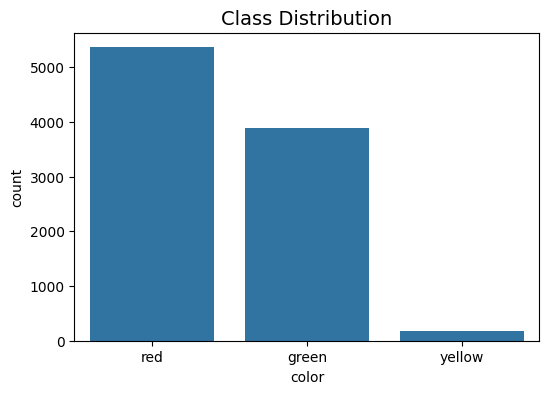

In [ ]:
plt.figure(figsize=(6, 4))
plt.title('Class Distribution', fontsize= 14)
sns.countplot(x = "color", data = df);

In [ ]:
def plot_img(image_name):

    fig, ax = plt.subplots(2, 1, figsize = (14, 14))
    ax = ax.flatten()

    bbox = df[df['filename'] == image_name]
    img_path = os.path.join(DIR_IMAGES, image_name)

    image = cv2.imread(img_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image /= 255.0
    image2 = image

    ax[0].set_title('Original Image')
    ax[0].imshow(image)

    for idx, row in bbox.iterrows():
        x1 = row['xmin']
        y1 = row['ymin']
        x2 = row['xmax']
        y2 = row['ymax']
        label = row['color']
        if label == 'red':
            color_brg = (255,0,0)
        elif label == 'green':
            color_brg = (0,255,0)
        elif label == 'yellow':
            color_brg = (0,255,255)

        cv2.rectangle(image2, (int(x1),int(y1)), (int(x2),int(y2)), color_brg, 3)
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(image2, label, (int(x1),int(y1-10)), font, 1, color_brg, 2)

    ax[1].set_title('Image with Bondary Box')
    ax[1].imshow(image2)

    plt.show()

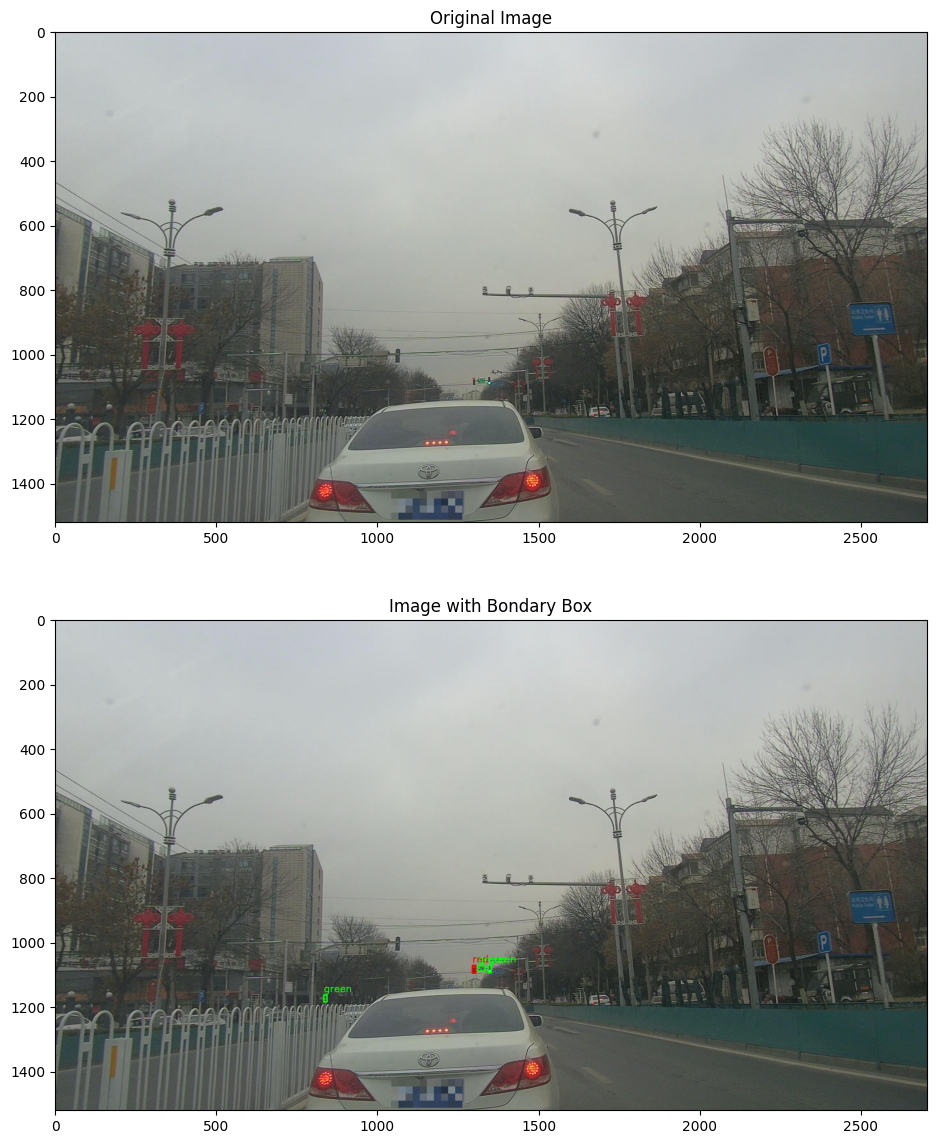

In [ ]:
plot_img("00004.jpg")

In [ ]:
_classes = np.insert(classes, 0, "background", axis=0)
class_to_int = {_classes[i] : i for i in range(len(_classes))}
int_to_class = {i : _classes[i] for i in range(len(_classes))}
print("class_to_int : \n",class_to_int)
print("\nint_to_class : \n",int_to_class)

class_to_int : 
 {'background': 0, 'red': 1, 'green': 2, 'yellow': 3}

int_to_class : 
 {0: 'background', 1: 'red', 2: 'green', 3: 'yellow'}


In [ ]:
class TrafficLightDetectionDataset(Dataset):

    def __init__(self, dataframe, image_dir, mode='train', transforms=None, resize_factor=0.25):
        super().__init__()

        self.image_names = dataframe['filename'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
        self.mode = mode
        self.resize_factor = resize_factor

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, index: int):
        #從 df 中檢索影像名稱及其記錄（x1、y1、x2、y2、classname）
        image_name = self.image_names[index]
        records = self.df[self.df['filename'] == image_name]

        #讀取圖片
        image_path = f"{self.image_dir}/{image_name}"
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)

        if image is None:
            print(f"Error: Image not found or cannot be read: {image_path}")
            return None, None, image_name

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        if self.mode == 'train':
            #取得每個框的邊界框座標
            boxes = records[['xmin', 'ymin', 'xmax', 'ymax']].values

            #取得每個邊界框的標籤
            temp_labels = records[['color']].values
            labels = [class_to_int[label[0]] for label in temp_labels]

            #將邊界框和標籤轉換為torch張量
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)

            #調整影像和邊界框的大小
            height, width, _ = image.shape
            new_height, new_width = int(height * self.resize_factor), int(width * self.resize_factor)
            image = cv2.resize(image, (new_width, new_height))
            boxes = boxes * self.resize_factor
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

            #建立目標
            target = {
                'boxes': boxes,
                'labels': labels,
                'area': torch.as_tensor(area, dtype=torch.float32)
            }

            #轉換
            if self.transforms:
                image = self.transforms(image)

            return image, target, image_name

        elif self.mode == 'test':
            #調整圖片大小
            height, width, _ = image.shape
            new_height, new_width = int(height * self.resize_factor), int(width * self.resize_factor)
            image = cv2.resize(image, (new_width, new_height))

            if self.transforms:
                image = self.transforms(image)

            return image, image_name

        return None, None, image_name

In [ ]:
#準備訓練和驗證數據

def get_transform():
    return T.Compose([T.ToTensor()])

def collate_fn(batch):
    batch = list(filter(lambda x: x[0] is not None, batch))  #過濾掉無效影像
    return tuple(zip(*batch)) if batch else ([], [], [])


#資料集對象
dataset = TrafficLightDetectionDataset(df, DIR_IMAGES, transforms = get_transform())


#將資料集拆分為訓練集和測試集 - 使用 80% 用於訓練，20% 用於驗證
indices = torch.randperm(len(dataset)).tolist()
train_dataset = torch.utils.data.Subset(dataset, indices[:-490])
valid_dataset = torch.utils.data.Subset(dataset, indices[-490:])


#準備資料載入器
train_data_loader = DataLoader(
    train_dataset,
    batch_size = 2,
    shuffle = True,
    num_workers = 2,
    collate_fn = collate_fn
)


valid_data_loader = DataLoader(
    valid_dataset,
    batch_size = 2,
    shuffle = True,
    num_workers = 2,
    collate_fn = collate_fn
)

In [ ]:
# Utilize GPU if available

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.empty_cache()

In [ ]:
#建立/載入模型

#Faster - RCNN 模型
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=None, weights_backbone=None)
num_classes = len(class_to_int)

#取得分類器的輸入特徵數量
in_features = model.roi_heads.box_predictor.cls_score.in_features

#將預先訓練好的頭部更換為新頭部資料
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

#準備訓練模型
#從模型中檢索所有可訓練參數（用於最佳化器）
params = [p for p in model.parameters() if p.requires_grad]
#定義優化器
optimizer = torch.optim.Adam(params, lr = 0.0001)
#LR
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
model.to(device)
#epochs
epochs = 5

In [ ]:
itr = 1
total_train_loss = []
for epoch in range(epochs):
    start_time = time.time()
    train_loss = []
    for images, targets, image_names in tqdm(train_data_loader):
        if not images:
            print("No valid images for this batch.")
            continue

        #在colab上載入圖像和目標
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        #前向傳播
        out = model(images, targets)
        losses = sum(loss for loss in out.values())

        #重置漸變
        optimizer.zero_grad()

        #反向傳播
        losses.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()

        #平均損失
        loss_value = losses.item()
        train_loss.append(loss_value)

        if itr % 300 == 0:
            print(f"\n Iteration #{itr} loss: {loss_value:.4f} \n")
        itr += 1
    lr_scheduler.step()

    epoch_train_loss = np.mean(train_loss)
    total_train_loss.append(epoch_train_loss)
    print(f'Epoch: {epoch+1}')
    print(f'Epoch train loss is {epoch_train_loss:.4f}')

    time_elapsed = time.time() - start_time
    print("Time elapsed: ", time_elapsed)

    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_train_loss
            }, "checkpoint.pth")


 30%|███       | 300/990 [03:25<07:51,  1.46it/s]


 Iteration #300 loss: 0.7204 



 61%|██████    | 600/990 [06:56<04:36,  1.41it/s]


 Iteration #600 loss: 0.8463 



 91%|█████████ | 900/990 [10:27<01:03,  1.41it/s]


 Iteration #900 loss: 0.4704 



100%|██████████| 990/990 [11:30<00:00,  1.43it/s]


Epoch: 1
Epoch train loss is 0.6766
Time elapsed:  690.3060350418091


 21%|██        | 210/990 [02:26<09:17,  1.40it/s]


 Iteration #1200 loss: 0.6791 



 52%|█████▏    | 510/990 [05:56<05:44,  1.40it/s]


 Iteration #1500 loss: 0.2399 



 82%|████████▏ | 810/990 [09:26<02:04,  1.44it/s]


 Iteration #1800 loss: 0.4944 



100%|██████████| 990/990 [11:32<00:00,  1.43it/s]


Epoch: 2
Epoch train loss is 0.5087
Time elapsed:  692.2469909191132


 12%|█▏        | 120/990 [01:23<10:25,  1.39it/s]


 Iteration #2100 loss: 0.3669 



 42%|████▏     | 420/990 [04:53<06:38,  1.43it/s]


 Iteration #2400 loss: 0.5122 



 73%|███████▎  | 720/990 [08:23<03:05,  1.45it/s]


 Iteration #2700 loss: 0.4188 



100%|██████████| 990/990 [11:33<00:00,  1.43it/s]


Epoch: 3
Epoch train loss is 0.4163
Time elapsed:  693.3164749145508


  3%|▎         | 30/990 [00:21<10:52,  1.47it/s]


 Iteration #3000 loss: 0.3013 



 33%|███▎      | 330/990 [03:50<07:34,  1.45it/s]


 Iteration #3300 loss: 0.1883 



 64%|██████▎   | 630/990 [07:20<04:16,  1.40it/s]


 Iteration #3600 loss: 0.3078 



 94%|█████████▍| 930/990 [10:51<00:41,  1.43it/s]


 Iteration #3900 loss: 0.4007 



100%|██████████| 990/990 [11:33<00:00,  1.43it/s]


Epoch: 4
Epoch train loss is 0.3916
Time elapsed:  693.6091079711914


 24%|██▍       | 240/990 [02:47<08:47,  1.42it/s]


 Iteration #4200 loss: 0.1987 



 55%|█████▍    | 540/990 [06:17<05:10,  1.45it/s]


 Iteration #4500 loss: 0.9040 



 85%|████████▍ | 840/990 [09:47<01:42,  1.46it/s]


 Iteration #4800 loss: 0.2341 



100%|██████████| 990/990 [11:32<00:00,  1.43it/s]


Epoch: 5
Epoch train loss is 0.3719
Time elapsed:  692.8006579875946


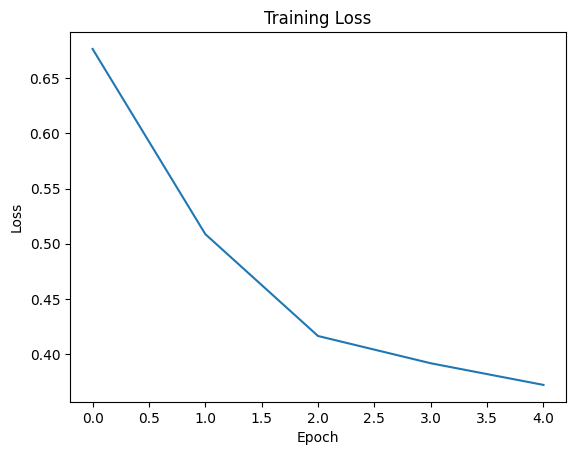

In [ ]:
plt.plot(total_train_loss)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [ ]:
itr = 1
v_loss = []

start_time = time.time()

for images, targets, image_names in tqdm(valid_data_loader):

    #在colab上載入圖像和目標
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    #前向傳播
    out = model(images, targets)
    losses = sum(loss for loss in out.values())

    #平均損失
    loss_value = losses.item()
    v_loss.append(loss_value)

val_loss = np.mean(v_loss)
print(f'Val loss is {val_loss:.4f}')

time_elapsed = time.time() - start_time
print("Time elapsed: ",time_elapsed)

100%|██████████| 245/245 [01:06<00:00,  3.67it/s]

Val loss is 0.4093
Time elapsed:  66.84853315353394


In [ ]:
folder_path = "/content/test_dataset/test_images"

file_names = os.listdir(folder_path)
df_test = pd.DataFrame({'filename': file_names})

In [ ]:
df_test

,filename
0,01215.jpg
1,02965.jpg
2,01826.jpg
3,02048.jpg
4,00698.jpg
...,...
395,00691.jpg
396,00930.jpg
397,02833.jpg
398,02554.jpg


In [ ]:
submission = pd.DataFrame(columns = ["filename", "xmin", "ymin", "xmax", "ymax", "color"])

#準備訓練數據
images = os.listdir(DIR_IMAGES_TEST)

df_test = df_test.drop_duplicates(subset='filename', keep="first")

#測試資料集
test_dataset = TrafficLightDetectionDataset(df_test, DIR_IMAGES_TEST, mode = 'test',
                                            transforms = get_transform())

#測試資料載入器
test_data_loader = DataLoader(
    test_dataset,
    batch_size=2,
    shuffle=False,
    num_workers=2,
    drop_last=False,
    collate_fn=collate_fn
)

In [ ]:
import gc

threshold = 0.7
model.eval()

for images, image_names in test_data_loader:
    for i, image in enumerate(images):
        #前向傳播 ->
        image = image.to(device).unsqueeze(0)  # 逐张图像处理
        output = model(image)

        #將張量轉換為數組
        boxes = output[0]['boxes'].data.cpu().numpy()
        scores = output[0]['scores'].data.cpu().numpy()
        labels = output[0]['labels'].data.cpu().numpy()

        #閾值化
        boxes_th = boxes[scores >= threshold].astype(np.int32)
        scores_th = scores[scores >= threshold]

        # int_to_class - labels
        labels_th = [int_to_class[labels[x]] for x in range(len(labels)) if scores[x] >= threshold]

        #建立暫存 DataFrame 用於批次追加
        temp_df = pd.DataFrame()

        for y in range(len(boxes_th)):
            # 邊界框、類別名稱和圖片名稱
            x1 = boxes_th[y][0] * 4
            y1 = boxes_th[y][1] * 4
            x2 = boxes_th[y][2] * 4
            y2 = boxes_th[y][3] * 4
            class_name = labels_th[y]

            # 為 df 建立行
            row = {
                "filename": image_names[i],
                "xmin": x1,
                "xmax": x2,
                "ymin": y1,
                "ymax": y2,
                "color": class_name
            }

            # 將新行追加到暫存 DataFrame
            temp_df = pd.concat([temp_df, pd.DataFrame([row])], ignore_index=True)

        # 將暫存 DataFrame 追加到 submission DataFrame
        submission = pd.concat([submission, temp_df], ignore_index=True)

        # 清理 GPU 内存
        del image
        torch.cuda.empty_cache()
        gc.collect()

In [ ]:
print(submission)

      filename  xmin  ymin  xmax  ymax  color
0    01215.jpg  2052  1116  2068  1148    red
1    01215.jpg  1616   980  1644  1048    red
2    01215.jpg  1788   976  1816  1044    red
3    01215.jpg  1704   980  1732  1048    red
4    01215.jpg  1704   980  1764  1008    red
..         ...   ...   ...   ...   ...    ...
934  02833.jpg  1348  1016  1368  1056  green
935  02833.jpg  1308  1016  1324  1056    red
936  02554.jpg  2136  1052  2156  1104    red
937  02554.jpg  2160  1052  2180  1108  green
938  02554.jpg  1112   684  1136   740  green

[939 rows x 6 columns]


In [ ]:
submission.to_csv('submission.csv', index = False)

In [ ]:
df = pd.read_csv('/content/submission.csv')
df.head(15)

,filename,xmin,ymin,xmax,ymax,color
0,01215.jpg,2052,1116,2068,1148,red
1,01215.jpg,1616,980,1644,1048,red
2,01215.jpg,1788,976,1816,1044,red
3,01215.jpg,1704,980,1732,1048,red
4,01215.jpg,1704,980,1764,1008,red
5,01215.jpg,2052,1116,2068,1148,red
6,01215.jpg,1616,980,1644,1048,red
7,01215.jpg,1788,976,1816,1044,red
8,01215.jpg,1704,980,1732,1048,red
9,01215.jpg,1704,980,1764,1008,red


In [ ]:
def plot_img_test(image_name):

    fig, ax = plt.subplots(2, 1, figsize = (14, 14))
    ax = ax.flatten()

    bbox = df[df['filename'] == image_name]
    img_path = os.path.join(DIR_IMAGES_TEST, image_name)

    image = cv2.imread(img_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image /= 255.0
    image2 = image

    ax[0].set_title('Original Image')
    ax[0].imshow(image)

    for idx, row in bbox.iterrows():
        x1 = row['xmin']
        y1 = row['ymin']
        x2 = row['xmax']
        y2 = row['ymax']
        label = row['color']
        if label == 'red':
            color_brg = (255,0,0)
        elif label == 'green':
            color_brg = (0,255,0)
        elif label == 'yellow':
            color_brg = (0,255,255)

        cv2.rectangle(image2, (int(x1),int(y1)), (int(x2),int(y2)), color_brg, 3)
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(image2, label, (int(x1),int(y1-10)), font, 1, color_brg, 2)

    ax[1].set_title('Image with Bondary Box')
    ax[1].imshow(image2)

    plt.show()

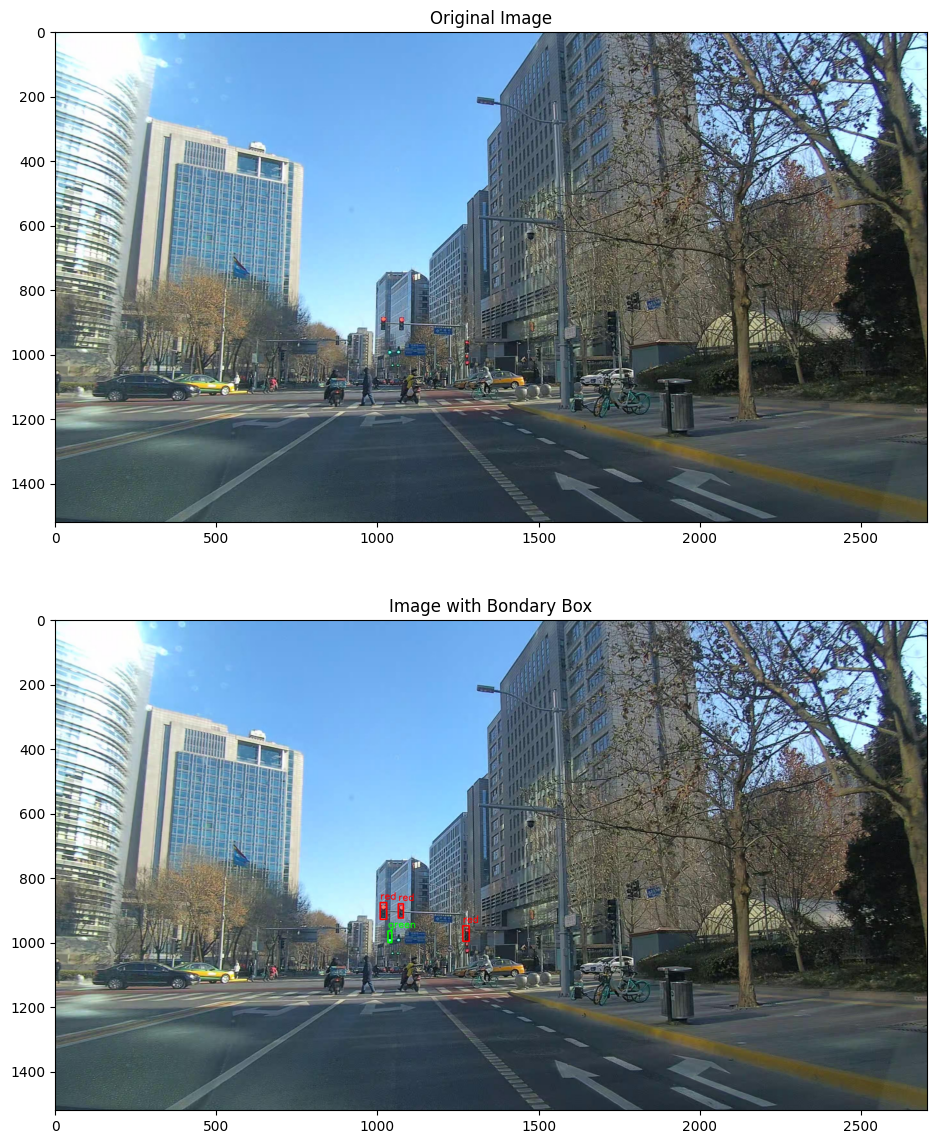

In [ ]:
plot_img_test('00069.jpg')